In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [10]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=15):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
cnnnet = CNNNet()

In [13]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
                               targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [14]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])
train_data_path = "classification_dataset/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "classification_dataset/validation/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [15]:
cnnnet.to(device)
optimizer = optim.Adam(cnnnet.parameters(), lr=0.001)

In [16]:
train(cnnnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=50, device=device)

Epoch: 1, Training Loss: 3.09, Validation Loss: 2.76, accuracy = 0.12
Epoch: 2, Training Loss: 2.67, Validation Loss: 2.66, accuracy = 0.12
Epoch: 3, Training Loss: 2.62, Validation Loss: 2.65, accuracy = 0.12
Epoch: 4, Training Loss: 2.59, Validation Loss: 2.38, accuracy = 0.12
Epoch: 5, Training Loss: 2.34, Validation Loss: 2.25, accuracy = 0.25
Epoch: 6, Training Loss: 2.26, Validation Loss: 2.08, accuracy = 0.23
Epoch: 7, Training Loss: 2.02, Validation Loss: 1.87, accuracy = 0.34
Epoch: 8, Training Loss: 1.88, Validation Loss: 1.71, accuracy = 0.34
Epoch: 9, Training Loss: 1.68, Validation Loss: 1.51, accuracy = 0.34
Epoch: 10, Training Loss: 1.52, Validation Loss: 1.45, accuracy = 0.36
Epoch: 11, Training Loss: 1.40, Validation Loss: 1.71, accuracy = 0.36
Epoch: 12, Training Loss: 1.31, Validation Loss: 1.36, accuracy = 0.47
Epoch: 13, Training Loss: 1.20, Validation Loss: 0.96, accuracy = 0.60
Epoch: 14, Training Loss: 0.97, Validation Loss: 0.89, accuracy = 0.63
Epoch: 15, Trai

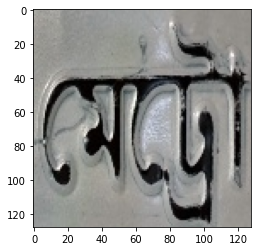

Metro


In [34]:
labels = ['zero','one','two','three',
            'four', 'five', 'six', 'seven',
            'eight', 'nine', 'CHA', 'Dhaka',
            'GA', 'GHA', 'Metro']

img = Image.open("classification_dataset/validation/Metro/Metro_361.jpg") 
image = cv2.imread("classification_dataset/validation/Metro/Metro_361.jpg")
plt.imshow(image)
plt.show()
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

cnnnet.eval()
prediction = F.softmax(cnnnet(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 